#  Use SARIMAX to model the time series process 

# Define global variable(train_end, predict_start, predict_end) and common functions

Define train and predict windows 

In [42]:
# for development 
# train_end='2019-6'
# predict_start='2019-7'
# predict_end='2019-9'

# for final submit 
train_end='2019-9'
predict_start='2019-10'
predict_end='2019-12'

## Auto_arima Function
note the d is default at  0 and trace =True. Can turn it off or change

In [ ]:
# suppress warning to make cleaner output 
import warnings
warnings.filterwarnings("ignore")

In [43]:
from matplotlib import pyplot as plt
%matplotlib inline
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [44]:
import pmdarima as pm 
def auto_arima(df,col_exog,d=0):
    try:
        results=pm.auto_arima(df[['stock_distributed']],
                              exog=df[col_exog],
                              seasonal=True,information_criterion='bic',m=12,
                          d=d, D=0, 
                          max_p=4, max_q=4, 
                          trace=False, # can turn Trace off 
                          error_action='ignore',
                          suppress_warnings=True)
        print(results.order)
        print(results.seasonal_order)
        #print(col_exog)
        return[results.order,results.seasonal_order] 
    except:
        print('error searching')

## SARIMAX - Region

It's region specific because the df_pred_agg_results_piece. The result collection part and the plot part assumes df is on regional level 

In [45]:

def predict_sarimax(df,order,seasonal_order,col_exog,plot=0):
    try:
        df_train=df[:train_end]
        df_test=df[predict_start:predict_end]
        model = SARIMAX(df_train['stock_distributed'], order=order,seasonal_order=seasonal_order,
                        exog=df_train[col_exog])
        result=model.fit()
        sarima_mean_insample=result.get_prediction(start=df_train.index[0],end=train_end,
                                                   exog=df_train[col_exog]).predicted_mean
        sarima_mean_outsample=result.get_prediction(start=predict_start,end=predict_end,
                                                    exog=df[predict_start:predict_end][col_exog]).predicted_mean
        sarima_mean_prediction=sarima_mean_insample.append(sarima_mean_outsample)
        district=df.iloc[0].district
        product_code=df.iloc[0].product_code
        
        df_pred_agg_results_piece=pd.DataFrame(data=sarima_mean_prediction,columns=['stock_distributed_forecasted'])
        df_pred_agg_results_piece['district']=district
        df_pred_agg_results_piece['product_code']=product_code 
        if plot==1:
            pd.DataFrame({'insample_pred':sarima_mean_insample,'outsample_pred':sarima_mean_outsample,'actual_value':df_train['stock_distributed']}).plot(); 
            plt.title(district+"--"+product_code)
            plt.show()
        return df_pred_agg_results_piece
    except:
        print('error')

# Import and process data 

## Import '../0_data/df_combined_fullsample.csv'

In [46]:
import pandas as pd
 #  contraceptive_logistics=pd.read_csv('../0_data/df_combined.csv') 
contraceptive_logistics=pd.read_csv('../0_data/df_combined_fullsample.csv')
contraceptive_logistics['day']=1
contraceptive_logistics['date']=pd.to_datetime(contraceptive_logistics[['year','month','day']])
contraceptive_logistics=contraceptive_logistics.sort_values('date')

## Aggregate on District level

In [47]:
col_continuous=['regionroads',
       'regionasphaltroads', 'regionearthroads', 'regionsurfacetreatmentroads',
       'regionpoorroads', 'poorroads', 'earthroads', 'asphaltroads',
       'site_type', 'product_type', 'temp', 'maxtemp', 'pressure',
       'relativehumidity', 'rainfallsnowmelt', 'visibility', 'windspeed',
       'maxsustainedwindspeed', 'rainordrizzle', 'storm', 'fog']
col_continuous.remove('site_type') # they are not continuous
col_continuous.remove('product_type') # they are not continuous

product_agg_level_sum=contraceptive_logistics.groupby(['district','product_code','date'])['stock_distributed'].sum()
df_product_agg_level_sum=pd.DataFrame(data=product_agg_level_sum)
df_product_agg_level_sum=df_product_agg_level_sum.reset_index()

for col in col_continuous:
    #print(col)
    df_product_agg_level_sum[col]=pd.DataFrame(data=contraceptive_logistics.groupby(['district','product_code','date'])[col].mean().values)
    
    

regionroads
regionasphaltroads
regionearthroads
regionsurfacetreatmentroads
regionpoorroads
poorroads
earthroads
asphaltroads
temp
maxtemp
pressure
relativehumidity
rainfallsnowmelt
visibility
windspeed
maxsustainedwindspeed
rainordrizzle
storm
fog


# SARIMAX

- need to write this part 

In [48]:
col_exog=col_continuous

### Test on a few example 

AGBOVILLE
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.53 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=239.923, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=244.506, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=244.329, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=253.235, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=242.213, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=242.086, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=242.984, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=243.030, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=244.876, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.428 seconds
(0, 0, 0)
(0, 0, 0, 12)


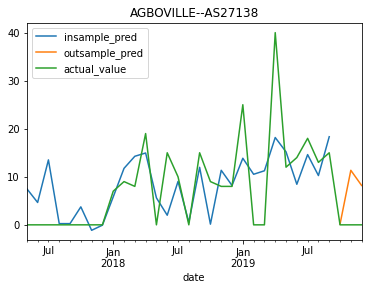

AGBOVILLE
AS27139
AGNIBILEKROU
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=285.904, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=292.824, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=293.216, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=296.324, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=289.761, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=289.752, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=288.976, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=289.374, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=285.973, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.469 seconds
(0, 0, 0)
(0, 0, 0, 12)


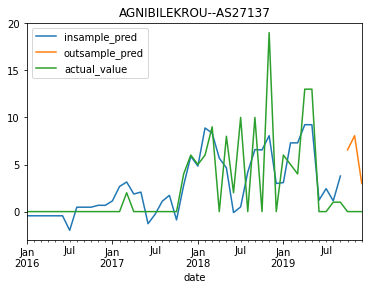

AGNIBILEKROU
AS27138


In [49]:
df_pred_district_product=pd.DataFrame()
for district in df_product_agg_level_sum['district'].unique()[6:8] :
    df1=df_product_agg_level_sum[df_product_agg_level_sum['district']==district];
    for product in df1['product_code'].unique()[6:8]:
        df2=df1[df1['product_code']==product].copy();
        df2['date']=pd.to_datetime(df2['date']);
        df2=df2.set_index(['date']);
        df2=df2.resample('MS').fillna('nearest')
        print(district)
        print(product)
        #fit_and_plot_forecast(df2)
        if(len(df2)>10):
            [order,seasonal_order]=auto_arima(df2,col_exog); 
            #result_piece= fit_and_plot_sarimax(df2,order,seasonal_order,col_exog);
            result_piece= predict_sarimax(df2,order,seasonal_order,col_exog,plot=1);
            # print(result_piece)
            df_pred_district_product=pd.concat([df_pred_district_product,result_piece])

## Run the full data df_product_agg_level_sum (district level) 

## Export '../2_pipeline/final_pred_district_lev.csv'

In [ ]:
run_full_data=0

In [50]:
if run_full_data==1:
    df_pred_district_product=pd.DataFrame()
    for district in df_product_agg_level_sum['district'].unique() :
        df1=df_product_agg_level_sum[df_product_agg_level_sum['district']==district];
        for product in df1['product_code'].unique():
            df2=df1[df1['product_code']==product].copy();
            df2['date']=pd.to_datetime(df2['date']);
            df2=df2.set_index(['date']);
            df2=df2.resample('MS').fillna('nearest')
            print(district)
            print(product)
            #fit_and_plot_forecast(df2)
            if(len(df2)>10):
                [order,seasonal_order]=auto_arima(df2,col_exog); 
                #result_piece= fit_and_plot_sarimax(df2,order,seasonal_order,col_exog);
                result_piece= predict_sarimax(df2,order,seasonal_order,col_exog,plot=0);
                # print(result_piece)
                df_pred_district_product=pd.concat([df_pred_district_product,result_piece])
    df_pred_district_product.to_csv('../2_pipeline/final_pred_district_lev.csv')

ABENGOUROU
AS17005
ABENGOUROU
AS21126
ABENGOUROU
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=418.591, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=398.112, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=404.491, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=404.658, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=444.195, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=400.891, Time=0.12 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=400.994, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=404.741, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=401.566, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=401.660, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=404.236, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.536 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ABENGOUROU
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=174.089, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=179.971, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=179.629, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=181.609, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=176.438, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=176.317, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=180.156, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=177.846, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=177.796, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=181.572, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.163 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ABENGOUROU
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=498.090, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=494.917, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=485.670, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=490.657, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=527.995, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=482.313, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=485.533, Time=0.14 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.42 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=483.991, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=484.541, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=488.799, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=487.813, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=485.135, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.851 seconds
(1, 0,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ABENGOUROU
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=441.409, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=447.971, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=448.062, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=462.650, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=444.386, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=444.390, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=448.261, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=444.960, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=445.049, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=448.066, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.513 seconds
(0, 0, 0)
(0, 0, 0, 12)
ABENGOUROU
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=105.293, 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ABENGOUROU
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=270.512, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=261.322, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=265.509, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=268.517, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=263.918, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=inf, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=266.998, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=261.640, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=263.238, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=261.635, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 0.907 seconds
(0, 0, 0)
(0, 0, 0, 12)
ABENGOUROU
AS27139
ABENGOUROU
AS46000
ABOBO-EST
AS17005
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1243.161, Time=0.02

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=64.792, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=inf, Time=0.36 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=64.020, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=62.639, Time=0.51 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : BIC=inf, Time=1.43 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : BIC=inf, Time=0.87 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : BIC=inf, Time=0.48 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : BIC=inf, Time=0.68 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : BIC=inf, Time=1.70 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.56 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=inf, Time=0.52 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : BIC=68.490, Time=0.43 

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ABOBO-EST
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=625.136, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=609.372, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=613.017, Time=0.22 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=614.220, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=651.032, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=613.012, Time=0.13 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=612.999, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=616.867, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=609.585, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=610.699, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=611.225, Time=0.12 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.499 seconds
(0, 0, 0)
(0, 0, 0, 12)
ABOBO-EST
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Ti

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ABOBO-EST
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=502.142, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=506.102, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=507.293, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=563.671, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=506.012, Time=0.12 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=506.012, Time=0.03 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=509.883, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=502.239, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=503.423, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=504.808, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.556 seconds
(0, 0, 0)
(0, 0, 0, 12)
ABOBO-EST
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


ABOBO-EST
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1243.161, Time=0.02 sec
Total fit time: 0.016 seconds
(0, 0, 0)
(0, 0, 0, 0)
ABOBO-EST
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1087.416, Time=0.01 sec
Total fit time: 0.017 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ABOBO-EST
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=320.414, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=328.105, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=328.103, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=317.554, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=324.258, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=324.258, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=328.123, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=324.263, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=324.262, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.15 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.525 seconds
(0, 0, 0)
(0, 0, 0, 12)
ABOISSO
AS21126
ABOISSO
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=4

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ABOISSO
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.79 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=201.017, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=208.473, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=208.444, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=198.820, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=204.763, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=204.760, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=204.730, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=204.707, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=208.439, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.555 seconds
(0, 0, 0)
(0, 0, 0, 12)
error
ABOISSO
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.6

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ABOISSO
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=364.105, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=368.929, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=369.243, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=384.828, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=366.270, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=366.400, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=366.585, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=366.739, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=370.360, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.568 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ABOISSO
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-957.643, Time=0.01 sec
Total fit time: 0.015 seconds
(0, 0, 0)
(0, 0, 0, 0)
ADIAKE
AS21126
ADIAKE
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=421.977, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=425.691, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=407.398, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=416.517, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=469.979, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=404.300, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=407.449, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=411.269, Time=0.37 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=407.831, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=407.777, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=412.787, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=411.753, Time=0.10 sec


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ADIAKE
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=297.622, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=285.833, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=284.906, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=287.240, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=307.648, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=281.035, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=284.906, Time=0.09 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=288.777, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=284.640, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=284.759, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=283.444, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=287.837, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=284.655, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 0.897 seconds
(1, 0,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ADIAKE
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=503.622, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=489.431, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=490.782, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=492.997, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=542.903, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=493.081, Time=0.13 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=493.099, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=496.948, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=487.944, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=490.707, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=494.531, Time=0.42 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=489.114, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=489.287, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=489.815, Time=0.04 sec
 ARIMA(2,0,1)(0,0,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


ADIAKE
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-879.788, Time=0.01 sec
Total fit time: 0.015 seconds
(0, 0, 0)
(0, 0, 0, 0)
ADIAKE
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-283.380, Time=0.01 sec
Total fit time: 0.014 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
ADIAKE
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=368.806, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=320.420, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=381.430, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=316.674, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=320.420, Time=0.07 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.50 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=320.055, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=320.169, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=323.622, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=313.895, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12]             : BIC=317.644, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[12]    

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ADJAME-PLATEAU-ATTECOUBE
AS17005
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.83 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=178.709, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=186.350, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=186.345, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=176.270, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=182.531, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=182.529, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.35 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=182.535, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=182.532, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.14 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.593 seconds
(0, 0, 0)
(0, 0, 0, 12)
ADJAME-PLATEAU-ATTECOUBE
AS21126
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-335.173, Time=0.02 sec
Total fit

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=616.032, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=633.918, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=621.128, Time=0.31 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=627.314, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=690.673, Time=0.00 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : BIC=612.580, Time=0.29 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : BIC=612.142, Time=0.12 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : BIC=614.650, Time=0.56 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : BIC=608.270, Time=0.14 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : BIC=610.822, Time=0.44 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : BIC=608.745, Time=0.39 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : BIC=611.766, Time=0.49 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : BIC=609.539, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=620.509, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[12] intercept   : BIC=612.144, Time=0.14 sec
 ARIMA(0,0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ADJAME-PLATEAU-ATTECOUBE
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=501.306, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=506.039, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=507.566, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=529.005, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=502.404, Time=0.11 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=503.696, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.32 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=504.908, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=504.888, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=508.681, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.712 seconds
(0, 0, 0)
(0, 0, 0, 12)
ADJAME-PLATEAU-ATTECOUBE
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] int

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ADJAME-PLATEAU-ATTECOUBE
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=574.363, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=581.253, Time=0.22 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=581.200, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=618.487, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=577.415, Time=0.14 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=577.347, Time=0.13 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.32 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=578.208, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=578.213, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=582.100, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.808 seconds
(0, 0, 0)
(0, 0, 0, 12)
ADJAME-PLATEAU-ATTECOUBE
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] int

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ADJAME-PLATEAU-ATTECOUBE
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=530.038, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=515.087, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=526.198, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=554.446, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=511.430, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=515.004, Time=0.14 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=518.455, Time=0.51 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=508.522, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=512.157, Time=0.25 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=512.047, Time=0.17 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.51 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=511.533, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=511.808, Time=0.09 sec
 ARIMA(1,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ADJAME-PLATEAU-ATTECOUBE
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=111.638, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=119.328, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=119.327, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=108.778, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=115.482, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=115.482, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=119.347, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=115.487, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=115.486, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.19 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.485 seconds
(0, 0, 0)
(0, 0, 0, 12)
ADJAME-PLATEAU-ATTECOUBE
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1113.372, Time=0.01 sec
Tota

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=434.222, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=441.912, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=441.910, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=431.376, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=438.065, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=438.065, Time=0.03 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=441.936, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=438.071, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=438.070, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.14 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.230 seconds
(0, 0, 0)
(0, 0, 0, 12)
ADZOPE
AS21126
ADZOPE
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=42

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ADZOPE
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=547.118, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=553.388, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=553.835, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=581.908, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=550.930, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=550.923, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=554.772, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=549.839, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=550.239, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=549.438, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.416 seconds
(0, 0, 0)
(0, 0, 0, 12)
ADZOPE
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=387.984, Time=0.4

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ADZOPE
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=191.829, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=196.859, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=196.841, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=210.050, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=193.785, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=193.785, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=196.964, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=194.699, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=194.691, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=197.868, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.138 seconds
(0, 0, 0)
(0, 0, 0, 12)
ADZOPE
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-646.277, Time=0.01 sec
Total fit time: 0.014 seconds
(0, 0, 

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=430.626, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=416.387, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=419.706, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=420.991, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=415.494, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=420.168, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=420.145, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=415.878, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=417.188, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=418.785, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.524 seconds
(0, 0, 0)
(0, 0, 0, 12)
AGBOVILLE
AS21126
AGBOVILLE
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=389.773, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[12] interc

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AGBOVILLE
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=156.938, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=162.602, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=162.369, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=164.229, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=159.230, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=159.067, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=160.255, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=160.058, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=162.341, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.285 seconds
(0, 0, 0)
(0, 0, 0, 12)
AGBOVILLE
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.58 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AGBOVILLE
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=428.687, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=423.731, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=429.362, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=429.340, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=428.875, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=425.633, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=425.607, Time=0.11 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=429.347, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=427.213, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=427.342, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=425.432, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.435 seconds
(0, 0, 0)
(0, 0, 0, 12)
AGBOVILLE
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Ti

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AGNIBILEKROU
AS27133
AGNIBILEKROU
AS27134
AGNIBILEKROU
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=285.904, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=292.824, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=293.216, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=296.324, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=289.761, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=289.752, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=288.976, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=289.374, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=285.973, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.270 seconds
(0, 0, 0)
(0, 0, 0, 12)
AGNIBILEKROU
AS27138
AGNIBILEKROU
AS27139
AGNIBILEKROU
AS46000
AKOUPE
AS21

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AKOUPE
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=320.851, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=327.751, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=327.715, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=326.876, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=324.722, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=324.722, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.35 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=323.911, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=323.881, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=327.750, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.414 seconds
(0, 0, 0)
(0, 0, 0, 12)
AKOUPE
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=512.088, Time=0.60 se

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AKOUPE
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=574.394, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=555.605, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=559.181, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=559.550, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=568.513, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=555.795, Time=0.16 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=556.069, Time=0.13 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=559.593, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=557.901, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=558.258, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=561.408, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.658 seconds
(0, 0, 0)
(0, 0, 0, 12)
AKOUPE
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.6

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AKOUPE
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=364.932, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=344.427, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=354.078, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=382.748, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=340.744, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=344.425, Time=0.10 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.36 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=343.089, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=340.965, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=351.982, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=344.596, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=339.588, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12]             : BIC=342.862, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[12]  

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


AKOUPE
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1165.286, Time=0.01 sec
Total fit time: 0.016 seconds
(0, 0, 0)
(0, 0, 0, 0)
AKOUPE
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1061.460, Time=0.01 sec
Total fit time: 0.016 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ALEPE
AS21126
ALEPE
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=266.104, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=273.147, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=273.148, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=276.818, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=269.611, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=269.612, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=273.138, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=269.627, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=269.627, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=273.183, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.447 seconds
(0, 0, 0)
(0, 0, 0, 12)
ALEPE
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ALEPE
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=382.744, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=388.564, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=386.442, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=412.726, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=385.036, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=382.885, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=386.021, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=386.118, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=389.210, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.404 seconds
(0, 0, 0)
(0, 0, 0, 12)
error
ALEPE
AS27137
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1191.244, Time=0.01 sec
Total fit time: 0.015 seconds
(0, 0,

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=294.959, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=289.727, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=294.815, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=285.906, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=289.726, Time=0.08 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.45 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=288.181, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=283.244, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12]             : BIC=287.073, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12]             : BIC=287.073, Time=0.05 sec
 ARIMA(1,0,0)(1,0,1)[12]          

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ALEPE
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1191.244, Time=0.01 sec
Total fit time: 0.016 seconds
(0, 0, 0)
(0, 0, 0, 0)
ALEPE
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=511.851, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=495.580, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=501.372, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=501.829, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=531.797, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=498.631, Time=0.13 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=498.859, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=502.064, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=498.237, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=498.519, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=501.483, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.554 seconds
(0, 0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ANYAMA
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=477.161, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=476.699, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=479.559, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=511.408, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=473.124, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=476.658, Time=0.14 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=480.513, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=475.355, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=475.896, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=475.718, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=479.187, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=479.091, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.614 seconds
(1, 0, 0)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ANYAMA
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=489.630, Time=0.58 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=491.356, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=481.658, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=488.592, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=540.464, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=478.155, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=480.873, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=484.213, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=477.280, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=480.845, Time=0.19 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=480.549, Time=0.19 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=484.181, Time=0.31 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=481.124, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=479.494, Time=0.09 sec
 ARIMA(1,0,1)(0,0,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ANYAMA
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=373.423, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=379.719, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=379.600, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=400.628, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=376.571, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=376.361, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.35 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=376.652, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=376.547, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=380.359, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.576 seconds
(0, 0, 0)
(0, 0, 0, 12)
ANYAMA
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.67 sec
 A

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ANYAMA
AS42018
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=88.710, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=inf, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=89.747, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=91.181, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=91.317, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=92.542, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.504 seconds
(0, 0, 0)
(0, 0, 0, 12)
error
ANYAMA
AS46000
BANGOLO
AS21126
BANGOLO
AS27000
BANGOLO
AS27132
BANGOLO
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BANGOLO
AS27138
BANGOLO
AS42018
BANGOLO
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=457.874, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=461.916, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=460.938, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=457.945, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=461.028, Time=0.12 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=461.030, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=464.454, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=459.004, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=458.288, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=461.662, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.411 seconds
(0, 0, 0)
(0, 0, 0, 12)
BEOUMI
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] in

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BEOUMI
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=346.108, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=353.415, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=353.428, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=350.827, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=349.797, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=349.797, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=349.730, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=349.744, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=351.473, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.526 seconds
(0, 0, 0)
(0, 0, 0, 12)
error
BEOUMI
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.60 

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=391.293, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=384.801, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=376.951, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=377.892, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=407.248, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=378.922, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : BIC=380.692, Time=0.37 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=380.653, Time=0.26 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=377.851, Time=0.13 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : BIC=inf, Time=1.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=381.588, Time=0.09 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=380.546, Time=0.16 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : BIC=380.435, Time=0.17 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=376.810, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=378.581, Time=0.03 sec
 ARIMA(0,0,1)(

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BETTIE
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.58 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=410.836, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=415.189, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=415.837, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=417.126, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=414.356, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=414.222, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=417.946, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=411.455, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=412.211, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=415.104, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.416 seconds
(0, 0, 0)
(0, 0, 0, 12)
BETTIE
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.67 se

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1886: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1886: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


BETTIE
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-464.747, Time=0.01 sec
Total fit time: 0.014 seconds
(0, 0, 0)
(0, 0, 0, 0)
BIANKOUMA
AS17005
BIANKOUMA
AS27000
Performing stepwise search to minimize bic


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=313.869, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=321.379, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=321.339, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=326.959, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=317.584, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=317.546, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.39 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=317.659, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=317.659, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=321.479, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.431 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BIANKOUMA
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=205.617, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=212.329, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=212.058, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=209.857, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=209.120, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=209.013, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=212.436, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=208.892, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=208.775, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=212.067, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 0.997 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
BIANKOUMA
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=368.174, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=360.257, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=364.088, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=398.837, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=358.337, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=360.549, Time=0.07 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=363.523, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=359.859, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=360.526, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=363.516, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=363.659, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=361.387, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.500 seconds
(

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BIANKOUMA
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=398.068, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=378.841, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=385.472, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=385.631, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=380.878, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=382.359, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=382.390, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=385.980, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=381.833, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=381.987, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=385.519, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.349 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BIANKOUMA
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=334.863, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=342.336, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=342.346, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=357.384, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=338.510, Time=0.11 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=338.519, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=342.337, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=338.689, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=338.689, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=342.520, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.485 seconds
(0, 0, 0)
(0, 0, 0, 12)
BIANKOUMA
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BLOLEQUIN
AS27132
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-386.990, Time=0.01 sec
Total fit time: 0.014 seconds
(0, 0, 0)
(0, 0, 0, 0)
BLOLEQUIN
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=440.930, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=431.042, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=440.345, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=500.132, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=427.616, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=431.082, Time=0.14 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.40 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=420.415, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=424.243, Time=0.31 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=424.243, Time=0.16 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.42 sec
 ARIMA(3,0,0)(0,0,0)[1

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BLOLEQUIN
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=98.084, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=83.939, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=87.485, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=86.820, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=89.822, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=86.054, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=86.054, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=88.827, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=85.126, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=84.526, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=87.258, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 0.945 seconds
(0, 0, 0)
(0, 0, 0, 12)
BLOLEQUIN
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.49 sec

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BOCANDA
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=471.732, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=479.077, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=479.143, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=481.461, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=475.602, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=475.602, Time=0.03 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=479.473, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=475.208, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=475.274, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=478.375, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.333 seconds
(0, 0, 0)
(0, 0, 0, 12)
BOCANDA
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.63 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BOCANDA
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=263.870, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=269.514, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=249.302, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=249.095, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=267.684, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=245.225, Time=0.11 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=249.095, Time=0.39 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=252.938, Time=0.68 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=248.420, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : BIC=248.422, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=245.440, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : BIC=252.271, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[12]             : BIC=242.510, Time=0.06 sec
 ARIMA(0,0,1)(1,0,0)[12]             : BIC=246.378, Time=0.24 sec
 ARIMA(0,0,1)(0,0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BONDOUKOU
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=287.558, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=277.510, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=278.504, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=277.407, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=291.838, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=281.091, Time=0.02 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=281.256, Time=0.17 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : BIC=281.237, Time=0.26 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=278.562, Time=0.08 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : BIC=inf, Time=1.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=273.713, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=277.558, Time=0.07 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : BIC=277.531, Time=0.17 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=275.005, Time=0.07 sec
 ARIMA(0,0,0)(1,0,2

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


BONDOUKOU
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=309.473, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=316.803, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=316.902, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=371.495, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=313.321, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=313.331, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=312.939, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=313.038, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=313.668, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.620 seconds
(0, 0, 0)
(0, 0, 0, 12)
BONDOUKOU
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.64 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BONDOUKOU
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=161.249, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=168.573, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=168.616, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=185.257, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=165.051, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=165.058, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.32 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=164.718, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=164.768, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=168.472, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.389 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BONDOUKOU
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=150.761, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=134.324, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=140.970, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=140.705, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=146.435, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=137.279, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=137.046, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=140.419, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=138.033, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=138.032, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=141.752, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.184 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BONDOUKOU
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-775.994, Time=0.01 sec
Total fit time: 0.015 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
BONDOUKOU
AS42018
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=167.635, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=174.592, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=174.583, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=176.799, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=170.956, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=170.946, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=171.235, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=171.236, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=174.687, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.295 seconds


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BONGOUANOU
AS17005
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=620.265, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=627.955, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=627.954, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=617.417, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=624.110, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=624.108, Time=0.03 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=627.979, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=624.114, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=624.113, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=627.988, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.309 seconds
(0, 0, 0)
(0, 0, 0, 12)
BONGOUANOU
AS21126
BONGOUANOU
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercep

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BONGOUANOU
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=371.608, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=388.180, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=368.023, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=382.124, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=390.931, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=364.203, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=368.020, Time=0.07 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.44 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=360.522, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=364.380, Time=0.14 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=364.379, Time=0.14 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.51 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=360.396, Time=0.05 sec
 ARIMA(3,0,0)(1,0,0)[12] intercept   : BIC=364.241, Time=0.20 sec
 ARIMA(3,0,0)(0,0,1)[1

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BONGOUANOU
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-412.905, Time=0.01 sec
Total fit time: 0.015 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
BONGOUANOU
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=92.134, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=71.765, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=77.529, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=77.269, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=87.356, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=74.236, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=73.926, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=77.611, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=74.603, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=74.455, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=78.260, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.364 seconds
(

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BOUAFLE
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=568.451, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=574.084, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=573.799, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=601.958, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=572.319, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=572.299, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=576.171, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=570.213, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=569.931, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=573.834, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.308 seconds
(0, 0, 0)
(0, 0, 0, 12)
BOUAFLE
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.61 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BOUAFLE
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=548.473, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=522.506, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=532.871, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=566.682, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=519.531, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=522.409, Time=0.11 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.42 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=523.066, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=523.172, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=531.146, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=527.221, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=518.478, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12]             : BIC=521.884, Time=0.08 sec
 ARIMA(1,0,0)(0,0,1)[12] 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BOUAFLE
AS42018
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=277.016, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=256.190, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=263.195, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=263.113, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=255.601, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=259.720, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=259.661, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=263.304, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=259.663, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=259.631, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=263.299, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.134 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BOUAFLE
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=497.617, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=475.438, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=482.320, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=482.230, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=485.417, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=478.460, Time=0.11 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=478.364, Time=0.09 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=482.156, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=479.272, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=479.268, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=483.122, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.244 seconds
(0, 0, 0)
(0, 0, 0, 12)
BOUAKE NORD-OUEST
AS17005
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=i

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BOUAKE NORD-OUEST
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=192.762, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=173.527, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=228.713, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=170.270, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=173.527, Time=0.09 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.33 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=173.245, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=173.359, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=185.072, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=175.463, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=168.507, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12]             : BIC=171.754, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimiz

BOUAKE NORD-OUEST
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-672.218, Time=0.01 sec
Total fit time: 0.016 seconds
(0, 0, 0)
(0, 0, 0, 0)
BOUAKE NORD-OUEST
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-672.218, Time=0.02 sec
Total fit time: 0.017 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BOUAKE NORD-OUEST
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=298.564, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=304.160, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=304.012, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=302.470, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=301.773, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=301.750, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=300.950, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=300.834, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.719 seconds
(0, 0, 0)
(0, 0, 0, 12)
BOUNA
AS17005
BOUNA
AS21126
BOUNA
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] inter

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BOUNA
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=111.638, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=119.328, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=119.327, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=108.778, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=115.482, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=115.482, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=119.347, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=115.487, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=115.486, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.16 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.376 seconds
(0, 0, 0)
(0, 0, 0, 12)
BOUNA
AS42018
BOUNA
AS46000
BOUNDIALI
AS17005
BOUNDIALI
AS21126
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-335.173, Time=0.

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=313.532, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=317.840, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=317.437, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=343.323, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=316.970, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=316.302, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=314.370, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=314.398, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=318.150, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.412 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BOUNDIALI
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=275.987, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=276.492, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=275.155, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=292.870, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=277.688, Time=0.03 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=inf, Time=0.44 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : BIC=278.310, Time=0.34 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=277.058, Time=0.11 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : BIC=inf, Time=0.84 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=273.633, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : BIC=inf, Time=0.61 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=275.624, Time=0.06 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept 

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


BOUNDIALI
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=525.839, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=506.460, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=510.659, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=510.739, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=547.915, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=510.161, Time=0.14 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=510.153, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=514.004, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=506.887, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=507.020, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=510.712, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.331 seconds
(0, 0, 0)
(0, 0, 0, 12)
BOUNDIALI
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Ti

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
BOUNDIALI
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-983.596, Time=0.02 sec
Total fit time: 0.018 seconds
(0, 0, 0)
(0, 0, 0, 0)
BOUNDIALI
AS46000
COCODY-BINGERVILLE
AS17005
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=117.446, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=124.786, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=124.805, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=117.671, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=120.938, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=120.957, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=124.727, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=121.274, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=121.268, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.16 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Tot

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


COCODY-BINGERVILLE
AS21126
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=64.925, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=inf, Time=0.29 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=63.867, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=61.711, Time=0.57 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : BIC=inf, Time=1.22 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : BIC=inf, Time=0.81 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : BIC=inf, Time=0.42 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : BIC=inf, Time=0.59 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : BIC=inf, Time=1.19 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.53 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=inf, Time=

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


COCODY-BINGERVILLE
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=588.217, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=582.005, Time=0.25 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=587.823, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=661.415, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=578.715, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=582.057, Time=0.21 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=585.875, Time=0.44 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=577.438, Time=0.10 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=581.065, Time=0.37 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=581.102, Time=0.28 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.55 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=580.505, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=580.891, Time=0.14 sec
 ARIMA(1,0,1)(

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


COCODY-BINGERVILLE
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=490.675, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=496.581, Time=0.23 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=496.486, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=535.359, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=494.533, Time=0.13 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=494.532, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=498.403, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=492.780, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=492.672, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=495.947, Time=0.12 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.419 seconds
(0, 0, 0)
(0, 0, 0, 12)
COCODY-BINGERVILLE
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept  

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


COCODY-BINGERVILLE
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=616.199, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=625.012, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=609.814, Time=0.24 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=620.221, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=681.833, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=606.386, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=609.823, Time=0.27 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=613.722, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=604.453, Time=0.08 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=608.247, Time=0.32 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=608.250, Time=0.30 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=612.157, Time=0.27 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=607.445, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=607.734, Time=0.15 sec
 ARIMA

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


COCODY-BINGERVILLE
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=428.459, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=413.991, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=424.350, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=458.099, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=410.908, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=413.838, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.40 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=407.300, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=410.255, Time=0.17 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=410.066, Time=0.18 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.54 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=411.005, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=410.860, Time=0.09 sec
 ARIMA(1,0,1)(0,0,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


COCODY-BINGERVILLE
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=462.908, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=429.679, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=442.135, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=495.593, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=425.826, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=429.682, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.48 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=429.128, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=428.832, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=438.809, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=432.565, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=424.968, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12]             : BIC=428.737, Time=0.08 sec
 ARIMA(1,0,0)(

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


COCODY-BINGERVILLE
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=327.752, Time=0.76 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=310.292, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=316.809, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=316.885, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=311.427, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=313.445, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=313.359, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=317.058, Time=0.35 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=313.421, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=313.621, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=314.773, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.535 seconds
(0, 0, 0)
(0, 0, 0, 12)
COCODY-BINGERVILLE
AS42018
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] interce

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


COCODY-BINGERVILLE
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=495.395, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=501.957, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=501.512, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=507.849, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=498.675, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=498.404, Time=0.12 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.32 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=498.629, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=498.318, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.735 seconds
(0, 0, 0)
(0, 0, 0, 12)
DABAKALA
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=451.403, Ti

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=478.652, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=460.650, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=465.454, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=465.625, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=483.491, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=463.394, Time=0.13 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=463.127, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=466.565, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=463.643, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=463.928, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=466.454, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.707 seconds
(0, 0, 0)
(0, 0, 0, 12)
DABAKALA
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=299.266

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
DABAKALA
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.76 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=276.034, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=281.985, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=281.887, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=293.951, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=279.583, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=279.631, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=283.092, Time=0.39 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=278.180, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=278.119, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=281.990, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.541 seconds
(0, 0, 0)
(0, 0, 0, 12)
DABAKALA
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=381.648

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


DABAKALA
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-309.273, Time=0.02 sec
Total fit time: 0.023 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
DABOU
AS21126
DABOU
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=467.143, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=474.827, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=477.095, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=479.442, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=510.399, Time=0.00 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : BIC=463.424, Time=0.70 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : BIC=460.074, Time=0.24 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : BIC=463.499, Time=0.59 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : BIC=456.399, Time=0.14 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : BIC=459.815, Time=0.38 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : BIC=459.748, Time=0.33 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.61 sec

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


DABOU
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=487.777, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=480.962, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=482.214, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=483.906, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=498.839, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=483.033, Time=0.12 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=482.968, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=486.834, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=479.536, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=482.271, Time=0.17 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=486.083, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=478.254, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=481.554, Time=0.23 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=481.617, Time=0.20 sec
 ARIMA(2,0,0)(1,0,1

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


DABOU
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=638.757, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=637.688, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=639.270, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=662.723, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=638.062, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : BIC=638.701, Time=0.60 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.46 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=639.170, Time=0.23 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : BIC=641.218, Time=1.19 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=637.214, Time=0.18 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : BIC=639.303, Time=0.38 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=638.858, Time=0.14 sec
 ARIMA(0,0,0)(2,0,1)[12] interc

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


DABOU
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=641.311, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=625.276, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=634.690, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=670.559, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=622.508, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=625.340, Time=0.22 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=629.146, Time=0.34 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=624.057, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=623.788, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=631.205, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=627.658, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=623.615, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 2.143 seconds
(1, 0, 0)
(

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


DABOU
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=434.876, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=420.388, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=426.694, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=427.277, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=445.043, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=424.220, Time=0.12 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=424.222, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=428.093, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=422.849, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=423.439, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=423.540, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.147 seconds
(0, 0, 0)
(0, 0, 0, 12)
DABOU
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.73 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


DALOA
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=320.530, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=324.158, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=322.640, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=325.576, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=323.684, Time=0.11 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=323.482, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=321.163, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=320.510, Time=0.05 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=322.915, Time=0.13 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=326.081, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : BIC=323.518, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[12] interc

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
DALOA
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=455.606, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=441.090, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=444.716, Time=0.24 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=444.754, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=464.204, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=441.040, Time=0.10 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : BIC=444.911, Time=0.28 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=444.911, Time=0.24 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=441.222, Time=0.10 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : BIC=448.782, Time=0.36 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=444.779, Time=0.15 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : BIC=446.727, Time=0.31 sec
 ARIMA(0,0,0)(1,0,0)[12]             : BIC=466.737, Time=0.04 sec

Best model:  ARIMA(0,0,0)(1,0,0)[12] intercept
Total fit time: 2.859 seconds
(

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


DALOA
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=275.830, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=282.697, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=282.808, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=301.201, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=279.480, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=279.474, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.41 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=278.852, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=278.958, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=282.187, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.624 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


DALOA
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1009.550, Time=0.01 sec
Total fit time: 0.016 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
DALOA
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=244.383, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=250.750, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=250.745, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=242.185, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=247.581, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=247.581, Time=0.03 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=250.800, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=247.556, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=247.552, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.12 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.276 seconds
(0, 0, 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


DANANE
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=459.945, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=464.494, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=465.610, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=475.106, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=463.754, Time=0.13 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=463.739, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=460.681, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=461.806, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=461.607, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.470 seconds
(0, 0, 0)
(0, 0, 0, 12)
DANANE
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.59 sec
 A

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
DANANE
AS46000
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1191.244, Time=0.02 sec
Total fit time: 0.019 seconds
(0, 0, 0)
(0, 0, 0, 0)
DAOUKRO
AS17005


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1087.416, Time=0.02 sec
Total fit time: 0.018 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
DAOUKRO
AS21126
DAOUKRO
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=529.085, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=535.303, Time=0.23 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=535.250, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=549.556, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=531.434, Time=0.16 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=531.380, Time=0.14 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=535.243, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=532.672, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=532.725, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=536.476, Time=0.11 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.969 seconds

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


DAOUKRO
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.92 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=328.022, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=332.233, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=332.252, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=347.435, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=331.648, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=331.476, Time=0.11 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.41 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=328.877, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=329.063, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=330.041, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.924 seconds
(0, 0, 0)
(0, 0, 0, 12)
DAOUKRO
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=333.299, Time=0.77 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


DIDIEVI
AS21126
DIDIEVI
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=444.602, Time=1.02 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=433.377, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=434.806, Time=0.22 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=432.745, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=445.179, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=430.284, Time=0.03 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=433.190, Time=0.21 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=436.302, Time=0.29 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=434.150, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : BIC=434.143, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=432.377, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : BIC=437.475, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[12]             : BIC=435.581, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[12] intercept
Total fit time: 2.2

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-724.103, Time=0.02 sec
Total fit time: 0.024 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
DIDIEVI
AS46000
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-724.103, Time=0.02 sec
Total fit time: 0.017 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


DIMBOKRO
AS21126
DIMBOKRO
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.91 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=342.558, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=338.694, Time=0.25 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=339.429, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=400.299, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=335.178, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=338.653, Time=0.23 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.59 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=338.527, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=338.433, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=336.146, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=341.962, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=337.290, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 2.561 sec

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


DIMBOKRO
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.83 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=188.158, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=192.607, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=191.021, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=208.326, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=191.333, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=191.399, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=194.848, Time=0.40 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=190.137, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=188.949, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=192.047, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.702 seconds
(0, 0, 0)
(0, 0, 0, 12)
DIMBOKRO
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.9

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


DIMBOKRO
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.85 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=279.455, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=262.519, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=273.780, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=303.801, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=262.465, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=262.395, Time=0.15 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=265.963, Time=0.27 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : BIC=265.967, Time=0.38 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : BIC=269.497, Time=1.30 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=280.109, Time=0.09 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=260.687, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=259.037, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=260.646, Time=0.20 sec
 ARIMA(2,0,0)(1,0,1)

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


DIMBOKRO
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=223.962, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=225.236, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=215.323, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=222.129, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=246.300, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=211.769, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=215.323, Time=0.10 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=218.876, Time=0.46 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=212.631, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=213.297, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=218.738, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=216.173, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=211.758, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12]             : BIC=215.189, Time=0.06 sec
 ARIMA(1,0,0)(0,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


DIMBOKRO
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-879.788, Time=0.02 sec
Total fit time: 0.023 seconds
(0, 0, 0)
(0, 0, 0, 0)
DIVO
AS21126
DIVO
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=1.13 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=560.495, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=563.302, Time=0.31 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=563.696, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=601.652, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=564.208, Time=0.13 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=564.198, Time=0.11 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=568.048, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=559.513, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=563.304, Time=0.16 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=567.154, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=563.362, Time=0.10 sec
 ARIMA(

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


DIVO
AS27132
DIVO
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=615.761, Time=0.85 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=607.832, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=605.998, Time=0.33 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=606.995, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=636.442, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=606.633, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : BIC=609.851, Time=1.03 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=609.752, Time=0.29 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=605.876, Time=0.31 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : BIC=609.747, Time=0.64 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : BIC=613.619, Time=0.73 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=605.048, Time=0.17 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : BIC=608.903, Time=0.52 sec
 ARIMA(0,0,

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


DIVO
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.84 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=523.682, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=528.491, Time=0.26 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=525.069, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=554.853, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=524.940, Time=0.16 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=521.323, Time=0.15 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : BIC=inf, Time=0.53 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : BIC=inf, Time=1.11 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=524.982, Time=0.25 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=527.262, Time=0.49 sec
 ARIMA(0,0,0)(0,0,1)[12]             : BIC=inf, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,1)[12] intercept
Total fit time: 4.389 seconds
(0, 0, 0)
(0, 0, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


DIVO
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.84 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=330.221, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=328.969, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=331.404, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=357.202, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=327.083, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=328.030, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.61 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=326.570, Time=0.09 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=327.502, Time=0.28 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=325.090, Time=0.22 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.68 sec
 ARIMA(2,0,0)(0,0,2)[12] intercept   : BIC=inf, Time=1.11 sec
 ARIMA(2,0,0)(1,0,2)[12] intercept   : BIC=inf, Time=1.04 sec
 ARIMA(3,0,0)(0,0,1)[12] intercept   : B

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


DIVO
AS42018
DIVO
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.83 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=301.153, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=303.869, Time=0.33 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=299.940, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=300.907, Time=0.16 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=304.059, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=304.030, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=307.117, Time=0.11 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 2.296 seconds
(0, 0, 0)
(0, 0, 0, 12)
error
DUEKOUE
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


error
DUEKOUE
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.91 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=293.318, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=291.606, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=292.135, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=332.859, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=288.354, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=291.269, Time=0.19 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.48 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=291.912, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=291.889, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=289.653, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=295.521, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=291.844, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 2.198 seconds
(1, 0, 

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.84 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=388.962, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=386.530, Time=0.23 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=385.435, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=426.796, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=381.777, Time=0.04 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=385.467, Time=0.18 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=inf, Time=0.47 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=385.447, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : BIC=385.403, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=382.864, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : BIC=387.018, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[12]             : BIC=404.201, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[12] intercept
Total fit time: 2.400 seconds
(0, 0, 1)
(0, 0, 0, 12)
FERKESSEDOUGOU
AS27132
Performing stepwise searc

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


FERKESSEDOUGOU
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.95 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=437.747, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=443.904, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=443.537, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=438.896, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=441.019, Time=0.14 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=440.942, Time=0.12 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.51 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=440.477, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=440.141, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=443.475, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 2.269 seconds
(0, 0, 0)
(0, 0, 0, 12)
FERKESSEDOUGOU
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=169.5

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


FERKESSEDOUGOU
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.81 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=325.302, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=299.031, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=311.793, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=328.976, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=295.240, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=299.033, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=302.765, Time=0.31 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=298.470, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=298.438, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=308.024, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=302.240, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=292.761, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12]             : BIC=296.565, Time=0.07 sec
 ARIMA(1,0,0)(

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


FRESCO
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=275.984, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=258.552, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=265.822, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=265.712, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=311.469, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=262.183, Time=0.13 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=262.000, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.46 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=262.149, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=262.216, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=263.643, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.781 seconds
(0, 0, 0)
(0, 0, 0, 12)
FRESCO
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.90 se

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


FRESCO
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=410.427, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=393.420, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=397.320, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=397.869, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=414.441, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=396.590, Time=0.13 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=396.540, Time=0.11 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=400.411, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=394.541, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=395.011, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=397.767, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.737 seconds
(0, 0, 0)
(0, 0, 0, 12)
FRESCO
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.6

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


FRESCO
AS27137
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-438.824, Time=0.01 sec
Total fit time: 0.016 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
FRESCO
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.92 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=204.596, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=207.575, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=207.568, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=221.667, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=206.250, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=207.067, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.46 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=205.067, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=204.808, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=208.362, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.884 seconds
(0, 0,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


FRESCO
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=112.546, Time=1.03 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=92.644, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=98.227, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=97.979, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=90.266, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=96.454, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=96.452, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=100.310, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=94.381, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=94.137, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=97.988, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.735 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GAGNOA
AS17005
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1009.550, Time=0.01 sec
Total fit time: 0.017 seconds
(0, 0, 0)
(0, 0, 0, 0)
GAGNOA
AS21126
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-335.173, Time=0.02 sec
Total fit time: 0.020 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GAGNOA
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=594.412, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=593.664, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=593.020, Time=0.34 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=593.192, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=653.822, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=590.010, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=592.566, Time=0.28 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=596.106, Time=0.53 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=589.545, Time=0.12 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=593.416, Time=0.36 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=593.415, Time=0.35 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=597.260, Time=0.35 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=579.571, Time=0.19 sec
 ARIMA(3,0,0)(1,0,0)[12] intercept   : BIC=583.071, Time=0.58 sec
 ARIMA(3,0,0)(0,0,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GAGNOA
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=474.900, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=481.416, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=481.600, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=489.676, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=477.544, Time=0.12 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=477.729, Time=0.15 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.45 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=478.763, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=478.762, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=482.633, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 2.117 seconds
(0, 0, 0)
(0, 0, 0, 12)
GAGNOA
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.99 sec
 A

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GAGNOA
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.85 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=536.255, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=537.073, Time=0.35 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=538.286, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=600.433, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=538.258, Time=0.19 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=538.403, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=542.121, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=534.070, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=537.195, Time=0.23 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=540.835, Time=0.50 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=537.268, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=537.490, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=535.418, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[1

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GAGNOA
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=363.998, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=381.117, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=355.675, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=367.914, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=402.251, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=352.803, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=355.561, Time=0.18 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=359.179, Time=0.35 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=351.800, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=355.650, Time=0.29 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=355.650, Time=0.18 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=359.500, Time=0.24 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=355.504, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=355.582, Time=0.08 sec
 ARIMA(1,0,1)(0,0,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GAGNOA
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=338.332, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=332.709, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=337.730, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=359.012, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=329.309, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=332.791, Time=0.14 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.48 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=330.973, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=331.555, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=334.253, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=334.630, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=330.784, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 2.115 seconds
(1, 0, 0)
(0, 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GAGNOA
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=1.05 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=226.689, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=231.632, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=232.394, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=228.196, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=229.296, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=229.262, Time=0.09 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=232.952, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=228.372, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=229.488, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=226.395, Time=0.06 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : BIC=230.033, Time=0.17 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=230.032, Time=0.17 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : BIC=233.738, Time=0.43 sec
 ARIMA(2,0,1)(0,0,0)[1

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=408.473, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=413.993, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=414.439, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=415.824, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=411.362, Time=0.12 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=411.517, Time=0.14 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.46 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=411.611, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=411.635, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.14 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 2.129 seconds
(0, 0, 0)
(0, 0, 0, 12)
GRAND-BASSAM
AS17005
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=1.11 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=209.359, Time=0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GRAND-BASSAM
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=1.06 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=399.998, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=407.678, Time=0.22 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=407.663, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=424.885, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=403.838, Time=0.14 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=403.831, Time=0.13 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.42 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=403.851, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=403.849, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=407.713, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 2.270 seconds
(0, 0, 0)
(0, 0, 0, 12)
GRAND-BASSAM
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=586.600, 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GRAND-BASSAM
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.97 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=587.340, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=526.646, Time=0.26 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=550.882, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=639.205, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=524.164, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=525.523, Time=0.24 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=527.985, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=527.994, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=556.222, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=531.270, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=522.408, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12]             : BIC=524.858, Time=0.11 sec
 ARIMA(1,0,0)(0,0,1)

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GRAND-BASSAM
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.89 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=376.187, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=344.069, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=407.431, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=340.337, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=343.996, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.38 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=344.203, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=344.189, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=339.529, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12]             : BIC=342.969, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[12]        

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GRAND-LAHOU
AS17005
GRAND-LAHOU
AS21126
GRAND-LAHOU
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.92 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=365.102, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=370.141, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=371.119, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=382.836, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=368.818, Time=0.13 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=368.746, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.51 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=366.428, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=367.464, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=365.503, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 2.178 seconds
(0, 0, 0)
(0, 0, 0, 12)
GRAND-LAHOU
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GRAND-LAHOU
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=218.334, Time=0.83 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=206.782, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=212.099, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=212.324, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=209.051, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=209.078, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=209.145, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=209.210, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=209.617, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=211.067, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.647 seconds
(0, 0, 0)
(0, 0, 0, 12)
error
GRAND-LAHOU
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=i

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GRAND-LAHOU
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.88 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=311.948, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=288.872, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=301.984, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=316.906, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=285.124, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=288.878, Time=0.10 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.58 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=288.800, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=288.838, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=298.360, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=291.274, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=282.618, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12]             : BIC=286.379, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GRAND-LAHOU
AS27139
GRAND-LAHOU
AS42018
GRAND-LAHOU
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=151.062, Time=0.89 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=145.577, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=147.039, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=139.536, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=144.583, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=136.476, Time=0.03 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=139.536, Time=0.15 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=142.627, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=139.561, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : BIC=139.559, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=143.963, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : BIC=141.850, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[12]             : BIC=134.537, Time=0.02 sec
 ARIMA(0,0,1)(1,0,0)[12]             : 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
GUEYO
AS21126
GUEYO
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.97 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=292.779, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=296.608, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=297.341, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=345.230, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=293.861, Time=0.11 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=294.422, Time=0.09 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=297.469, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=294.413, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=295.181, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=295.413, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.908 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GUEYO
AS27132
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1035.505, Time=0.01 sec
Total fit time: 0.017 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
GUEYO
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=408.433, Time=0.96 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=400.998, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=396.999, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=396.144, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=419.427, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=395.058, Time=0.04 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=395.914, Time=0.18 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=399.719, Time=0.48 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=398.123, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : BIC=397.856, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=394.986, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=396.921, Time=0.18 sec
 ARIMA(1,0,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GUEYO
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.84 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=315.602, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=318.790, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=311.424, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=316.610, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=307.812, Time=0.04 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=311.446, Time=0.17 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=inf, Time=0.47 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=311.269, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : BIC=311.157, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=315.158, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : BIC=314.303, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[12]             : BIC=306.872, Time=0.03 sec
 ARIMA(0,0,1)(1,0,0)[12]             : BIC=310.561, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12]   

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GUEYO
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=229.237, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=236.907, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=236.912, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=228.053, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=233.071, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=233.059, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.43 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=233.069, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=233.087, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=235.534, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.663 seconds
(0, 0, 0)
(0, 0, 0, 12)
GUEYO
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-801.941, Time=0.02 sec
Total fit time: 0.017 seconds
(0, 0, 0)
(0,

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.91 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=348.324, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=355.265, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=354.930, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=367.881, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=351.837, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=351.709, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=355.274, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=351.676, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=351.330, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=354.770, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.778 seconds
(0, 0, 0)
(0, 0, 0, 12)
GUIGLO
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.76 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=184.970, Time

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=644.629, Time=0.94 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=621.974, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=629.298, Time=0.25 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=629.293, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=621.610, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=625.669, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=625.663, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=629.530, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=625.557, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=625.563, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=629.426, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.747 seconds
(0, 0, 0)
(0, 0, 0, 12)
GUIGLO
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.84 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=390.919, 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GUIGLO
AS46000
GUITRY
AS17005
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.95 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=288.397, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=295.811, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=295.806, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=285.810, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=292.105, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=292.102, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.45 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=292.101, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=292.099, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.18 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 2.003 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
GUITRY
AS21126
GUITRY
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=371.645, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=354.826, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=358.822, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=358.557, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=385.950, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=356.393, Time=0.12 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=355.511, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.51 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=357.945, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=358.173, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=360.861, Time=0.12 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 2.145 seconds
(0, 0, 0)
(0, 0, 0, 12)
GUITRY
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : 

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GUITRY
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=399.475, Time=0.85 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=377.895, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=385.020, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=384.938, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=377.619, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=381.496, Time=0.12 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=381.468, Time=0.09 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=385.168, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=381.449, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=381.418, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.16 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.857 seconds
(0, 0, 0)
(0, 0, 0, 12)
error
GUITRY
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=275.343, Ti

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=1.18 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=47.835, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=54.837, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=54.723, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=47.675, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=51.297, Time=0.14 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=51.264, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=55.042, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=51.388, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=51.312, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.21 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 2.175 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ISSIA
AS21126
ISSIA
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.90 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=510.841, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=503.242, Time=0.34 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=504.932, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=566.510, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=501.664, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=502.284, Time=0.26 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=506.146, Time=0.32 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=505.525, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=505.533, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=504.710, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=508.690, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=507.902, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 2.551 secon

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ISSIA
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=400.370, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=407.882, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=407.868, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=430.340, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=404.011, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=403.997, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=407.866, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=404.207, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=404.215, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=406.799, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.405 seconds
(0, 0, 0)
(0, 0, 0, 12)
ISSIA
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.66 sec


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ISSIA
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=443.299, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=445.490, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=443.035, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=452.726, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=439.221, Time=0.04 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=443.045, Time=0.14 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=446.899, Time=0.24 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=442.926, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : BIC=442.871, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=441.773, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : BIC=inf, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[12]             : BIC=442.308, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[12] intercept
Total fit time: 1.740 seconds
(0, 0, 1)
(0, 0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ISSIA
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=396.882, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=405.659, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=390.376, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=395.523, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=425.515, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=388.355, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=390.395, Time=0.11 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=394.175, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=389.802, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=388.264, Time=0.06 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : BIC=390.160, Time=0.23 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=390.310, Time=0.18 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : BIC=393.989, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=393.994, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ISSIA
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=119.176, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=124.373, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=108.951, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=109.644, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=123.537, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=105.093, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=108.951, Time=0.08 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.51 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=105.107, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=105.660, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=105.870, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=108.978, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=101.898, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12]             : BIC=105.769, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ISSIA
AS42018
ISSIA
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=361.900, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=362.391, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=362.680, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=364.394, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=364.997, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=364.856, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=358.666, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=362.360, Time=0.06 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.39 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=362.531, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=362.516, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=359.173, Time=0.03 sec
 ARIMA(2,0,1)(0,0,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


JACQUEVILLE
AS21126
JACQUEVILLE
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=435.689, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=418.620, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=423.976, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=424.204, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=439.995, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=422.451, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=422.446, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.41 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=420.154, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=420.399, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=424.025, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.669 seconds
(0, 0, 0)
(0, 0, 0, 12)
JACQUEVILLE
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] inter

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


JACQUEVILLE
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=469.139, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=476.020, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=476.170, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=499.550, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=472.700, Time=0.11 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=472.787, Time=0.11 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=476.306, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=472.485, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=472.520, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=476.348, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.620 seconds
(0, 0, 0)
(0, 0, 0, 12)
JACQUEVILLE
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Ti

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


KATIOLA
AS17005
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-464.747, Time=0.01 sec
Total fit time: 0.014 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
KATIOLA
AS21126
KATIOLA
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=297.469, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=299.053, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=294.840, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=356.884, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=292.298, Time=0.02 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=294.692, Time=0.12 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=298.314, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=292.942, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : BIC=293.946, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=295.873, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : BIC=296.776, Time=0.10 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


KATIOLA
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=171.202, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=161.551, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=153.533, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=178.117, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=152.981, Time=0.03 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=154.113, Time=0.11 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=inf, Time=0.38 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=156.602, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : BIC=156.846, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=158.215, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : BIC=159.972, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[12]             : BIC=154.654, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[12] intercept
Total fit time: 1.575 seconds
(0, 0, 1)
(0,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


KATIOLA
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=468.960, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=468.940, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=471.648, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=496.077, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=465.485, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=468.783, Time=0.15 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.45 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=468.024, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=468.204, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=467.947, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=471.884, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=468.959, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.844 seconds
(1, 0, 0)
(0,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


KATIOLA
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=370.276, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=361.145, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=363.949, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=365.309, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=402.712, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=363.198, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=363.441, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=366.963, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=363.476, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=364.034, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=366.743, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.299 seconds
(0, 0, 0)
(0, 0, 0, 12)
KATIOLA
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


KATIOLA
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=418.520, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=419.053, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=420.502, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=444.421, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=421.644, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=421.862, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=425.143, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=415.485, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=419.160, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=422.561, Time=0.28 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=418.615, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=417.843, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=416.718, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


KATIOLA
AS27139
KATIOLA
AS42018
KATIOLA
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=436.824, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=444.173, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=444.163, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=438.129, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=440.577, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=440.619, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=443.491, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=440.352, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=440.325, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=444.148, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.531 seconds
(0, 0, 0)
(0, 0, 0, 12)
KORHOGO
AS17005
KORHOGO
AS21126
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1217.202, 

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=333.943, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=314.273, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=319.960, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=320.208, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=340.629, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=318.120, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=318.112, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=321.927, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=316.317, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=316.557, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=320.170, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.177 seconds
(0, 0, 0)
(0, 0, 0, 12)
KORHOGO
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=250.517,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


KORHOGO
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=556.623, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=564.070, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=564.065, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=576.471, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=560.473, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=560.470, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=564.340, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=560.191, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=560.195, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=564.063, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.312 seconds
(0, 0, 0)
(0, 0, 0, 12)
KORHOGO
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=375.649, Time=0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


KORHOGO
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=1.04 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=111.638, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=119.328, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=119.327, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=108.778, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=115.482, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=115.482, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=119.347, Time=0.30 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=115.487, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=115.486, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.17 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.792 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


KORHOGO
AS42018
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=188.333, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=195.946, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=195.941, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=186.793, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=192.112, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=192.107, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=192.156, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=192.155, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=196.026, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.489 seconds
(0, 0, 0)
(0, 0, 0, 12)
KORHOGO
AS46000
KORO
AS27000
KORO
AS27132
KORO
AS27133
KORO
AS27137
KORO
AS27138
KORO
AS27139
KORO
AS46000
KOUIBLY
AS1700

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
KOUIBLY
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.81 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=399.302, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=392.952, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=395.384, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=417.282, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=391.029, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=392.540, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.44 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=393.359, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=393.346, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=394.668, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=397.016, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=392.721, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.924 seconds
(1, 0, 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


KOUIBLY
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.79 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=286.212, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=293.477, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=293.393, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=297.974, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=289.852, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=289.865, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=289.792, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=289.679, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=293.256, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.537 seconds
(0, 0, 0)
(0, 0, 0, 12)
KOUIBLY
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=265.642, Time=0.40 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


KOUIBLY
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-516.601, Time=0.01 sec
Total fit time: 0.014 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
KOUIBLY
AS46000
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1191.244, Time=0.01 sec
Total fit time: 0.015 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


KOUMASSI-PORT BOUET-VRIDI
AS17005
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=228.005, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=235.136, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=234.782, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=230.395, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=231.876, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=231.876, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=235.748, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=231.265, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=230.911, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.15 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.249 seconds
(0, 0, 0)
(0, 0, 0, 12)
KOUMASSI-PORT BOUET-VRIDI
AS21126
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-335.173, Time=0.01 sec
Tot

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=706.374, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=694.384, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=697.192, Time=0.25 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=698.748, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=720.979, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=698.044, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=697.875, Time=0.12 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=701.760, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=694.510, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=695.783, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=697.055, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.675 seconds
(0, 0, 0)
(0, 0, 0, 12)
KOUMASSI-PORT BOUET-VRIDI
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercep

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


KOUMASSI-PORT BOUET-VRIDI
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=576.178, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=560.569, Time=0.25 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=565.645, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=616.279, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=557.211, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=560.104, Time=0.19 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=563.840, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=560.850, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=560.788, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=561.835, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=564.657, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=559.223, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.773

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


KOUMASSI-PORT BOUET-VRIDI
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=571.495, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=564.649, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=568.075, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=606.025, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=560.790, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=564.650, Time=0.17 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=568.521, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=564.474, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=564.198, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=564.254, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=567.703, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=564.655, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.805

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


KOUMASSI-PORT BOUET-VRIDI
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.76 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=498.675, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=504.324, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=503.321, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=524.954, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=502.464, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=502.457, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=506.329, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=500.490, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=499.582, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=502.813, Time=0.12 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.683 seconds
(0, 0, 0)
(0, 0, 0, 12)
KOUMASSI-PORT BOUET-VRIDI
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[1

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


KOUMASSI-PORT BOUET-VRIDI
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=158.267, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=154.890, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=159.376, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=158.199, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=151.076, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=154.887, Time=0.06 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.39 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=150.774, Time=0.02 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=154.629, Time=0.10 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=154.628, Time=0.09 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.52 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=153.789, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=154.327, Time=0.05 sec
 ARIMA(1,0,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


KOUMASSI-PORT BOUET-VRIDI
AS42018
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=158.639, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=165.508, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=165.499, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=166.448, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=162.240, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=162.204, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=161.877, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=161.889, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=165.566, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.263 seconds
(0, 0, 0)
(0, 0, 0, 12)
KOUMASSI-PORT BOUET-VRIDI
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] i

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
LAKOTA
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=429.259, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=422.997, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=423.870, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=425.632, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=440.096, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=425.247, Time=0.12 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=424.407, Time=0.09 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.32 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=420.786, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=423.817, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.43 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=423.620, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=424.259, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=422.865, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


LAKOTA
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=349.546, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=356.244, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=356.154, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=353.823, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=352.878, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=352.826, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=352.962, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=352.902, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.16 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.685 seconds
(0, 0, 0)
(0, 0, 0, 12)
error
LAKOTA
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=360.436, Time=0.65 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


M'BAHIAKRO
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=116.785, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=123.767, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=123.703, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=123.537, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=120.511, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=120.463, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=120.034, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=120.002, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=123.873, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.355 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


M'BAHIAKRO
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=436.287, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=442.604, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=442.455, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=457.007, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=439.870, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=439.851, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=439.131, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=439.056, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=442.899, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.579 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


M'BAHIAKRO
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=373.520, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=377.689, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=374.660, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=385.337, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=373.892, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=370.975, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : BIC=inf, Time=0.52 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : BIC=inf, Time=0.49 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=374.616, Time=0.12 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=378.280, Time=0.41 sec
 ARIMA(0,0,0)(0,0,1)[12]             : BIC=389.011, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,1)[12] intercept
Total fit time: 2.959 seconds
(0, 0, 0)
(0, 0, 1

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


M'BAHIAKRO
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=136.719, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=142.947, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=143.013, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=139.973, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=140.175, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=140.173, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=139.469, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=139.528, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=143.021, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.269 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


M'BAHIAKRO
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=157.046, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=163.521, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=163.610, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=164.864, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=160.300, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=160.286, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.30 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=160.416, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=160.469, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=162.554, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.303 seconds
(0, 0, 0)
(0, 0, 0, 12)
M'BAHIAKRO
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.6

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


M'BAHIAKRO
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-568.466, Time=0.01 sec
Total fit time: 0.015 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
MAN
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=272.936, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=277.814, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=277.962, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=277.177, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=274.525, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=274.643, Time=0.09 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=277.666, Time=0.35 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=275.860, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=275.950, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=278.586, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.522 seconds
(

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MAN
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.58 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=302.665, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=306.681, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=306.303, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=310.423, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=304.161, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=303.812, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=305.698, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=305.719, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=309.043, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.502 seconds
(0, 0, 0)
(0, 0, 0, 12)
MAN
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.56 sec
 ARIMA(0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MAN
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=252.176, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=258.310, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=258.365, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=262.033, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=255.260, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=255.274, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=255.334, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=255.353, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=258.503, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.377 seconds
(0, 0, 0)
(0, 0, 0, 12)
MAN
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-672.218, Time=0.02 sec
Total fit time: 0.019 seconds
(0, 0, 0)
(0, 0, 

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=379.115, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=371.453, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=371.963, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=425.936, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=368.530, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=371.207, Time=0.14 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.40 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=372.323, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=372.305, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=370.497, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=373.556, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.747 seconds
(1, 0, 0)
(0, 0, 0, 12)
MANKONO
AS27132
Performing stepwise search to minimi

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


MANKONO
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-594.401, Time=0.01 sec
Total fit time: 0.015 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
MANKONO
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-335.173, Time=0.01 sec
Total fit time: 0.014 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
MANKONO
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=449.932, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=453.244, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=454.769, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=489.650, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=453.566, Time=0.13 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=453.546, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=457.374, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=449.676, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=453.267, Time=0.15 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=457.066, Time=0.30 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=449.246, Time=0.07 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=453.050, Time=0.22 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=453.054, Time=0.17 sec
 ARIMA(2,0,0)(1

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=260.740, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=263.151, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=262.143, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=269.671, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=263.175, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=261.716, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=261.480, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=261.918, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=264.694, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.367 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MINIGNAN
AS27134
MINIGNAN
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=232.605, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=238.993, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=238.913, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=233.215, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=235.822, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=235.834, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.30 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=235.681, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=235.592, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=238.607, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.372 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MINIGNAN
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=205.354, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=211.427, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=211.338, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=208.446, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=208.367, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=208.234, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=208.416, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=208.455, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=211.602, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.316 seconds
(0, 0, 0)
(0, 0, 0, 12)
MINIGNAN
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-724.103, Time=0.01 sec
Total fit time: 0.017 seconds
(0, 0, 

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is co

error
NASSIAN
AS27132
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-335.173, Time=0.01 sec
Total fit time: 0.014 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
NASSIAN
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=255.195, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=255.123, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=257.363, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=262.893, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=251.894, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=255.124, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=258.525, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=252.712, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=253.359, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=254.332, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=255.959, Time=0.07 sec
 ARIMA

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


NASSIAN
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=97.773, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=104.184, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=104.139, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=96.556, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=100.994, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=100.981, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=100.980, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=100.959, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.294 seconds
(0, 0, 0)
(0, 0, 0, 12)
error
NASSIAN
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-335.173, Time=0.01 sec
Total fit time: 0.015 seconds
(0, 0, 0)

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=356.143, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=359.912, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=360.956, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=394.203, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=359.967, Time=0.11 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=359.949, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=356.112, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=359.897, Time=0.11 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=363.625, Time=0.38 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=358.389, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=356.673, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=357.227, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=360.422, Time=0.09 sec
 ARIMA(1,0,0)(0,0,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
NIAKARAMADOUGOU
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=503.842, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=512.631, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=495.505, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=503.841, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=551.708, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=493.608, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=495.403, Time=0.16 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.41 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=494.628, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=495.020, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=502.622, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=498.446, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=495.924, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.853 sec

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


NIAKARAMADOUGOU
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=253.250, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=235.812, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=244.426, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=287.495, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=232.027, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=235.794, Time=0.08 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=239.641, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=234.486, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=234.417, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=242.376, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=238.286, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=233.169, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.224 seconds
(

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


NIAKARAMADOUGOU
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=333.811, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=331.840, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=335.150, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=363.097, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=328.713, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=331.533, Time=0.11 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.40 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=330.266, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=329.212, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=331.748, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=333.078, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=333.495, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.602 seconds
(1, 0

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


NIAKARAMADOUGOU
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-386.990, Time=0.01 sec
Total fit time: 0.014 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
NIAKARAMADOUGOU
AS46000
ODIENNE
AS17005
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1243.161, Time=0.02 sec
Total fit time: 0.017 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ODIENNE
AS21126
ODIENNE
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=350.856, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=334.721, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=340.269, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=339.454, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=382.916, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=337.782, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=336.927, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=340.564, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=337.247, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=337.112, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=338.488, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.370 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ODIENNE
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=249.041, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=254.429, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=254.120, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=263.695, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=251.615, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=251.529, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=252.255, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=252.113, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=255.917, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.399 seconds
(0, 0, 0)
(0, 0, 0, 12)
error
ODIENNE
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.6

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ODIENNE
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=423.512, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=427.324, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=428.226, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=454.983, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=426.160, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=425.899, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=429.749, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=423.508, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=427.282, Time=0.11 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=430.885, Time=0.30 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=423.277, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=426.928, Time=0.22 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=426.752, Time=0.20 sec
 ARIMA(2,0,0)(1,0,1)[

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ODIENNE
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=422.293, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=415.876, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=408.426, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=409.348, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=439.500, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=406.543, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=408.120, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=411.955, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=410.381, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=410.293, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=407.354, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=413.764, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=409.072, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.717 seconds
(1, 0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
ODIENNE
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-412.905, Time=0.01 sec
Total fit time: 0.015 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
ODIENNE
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=303.760, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=310.610, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=310.370, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=306.068, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=307.626, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=307.628, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=306.760, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=306.515, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=304.166, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.479 second

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=458.706, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=459.727, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=458.840, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=512.795, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=461.597, Time=0.12 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=460.130, Time=0.13 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=463.420, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=457.685, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=457.424, Time=0.17 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=460.918, Time=0.42 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : BIC=460.790, Time=0.50 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : BIC=464.537, Time=0.98 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=461.057, Time=0.25 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=461.072, Time=0.27 sec
 ARIMA(2,0,1)(

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


OUANGOLO
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=497.606, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=505.134, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=505.119, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=498.591, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=501.352, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=501.336, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.35 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=501.389, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=501.389, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=505.173, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.605 seconds
(0, 0, 0)
(0, 0, 0, 12)
OUANGOLO
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.73 se

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


OUANGOLO
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.76 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=285.388, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=291.338, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=290.967, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=285.418, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=287.507, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=287.168, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=291.000, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=289.176, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=289.191, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=292.700, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.263 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


OUANGOLO
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1113.372, Time=0.01 sec
Total fit time: 0.016 seconds
(0, 0, 0)
(0, 0, 0, 0)
OUME
AS21126
OUME
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=372.415, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=372.591, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=371.518, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=454.245, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=367.647, Time=0.03 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=371.518, Time=0.15 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=375.385, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=371.513, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : BIC=371.516, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=368.738, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : BIC=374.469, Time=0.16 sec
 ARIMA

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


OUME
AS27137
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-438.824, Time=0.01 sec
Total fit time: 0.014 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
OUME
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=256.840, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=247.280, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=242.944, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=242.796, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=264.333, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=242.022, Time=0.02 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=242.622, Time=0.10 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=246.201, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=244.634, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : BIC=244.820, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=241.131, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=243.305, Time=0.08 sec
 ARIMA(1,0,0)(

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


OUME
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-827.889, Time=0.02 sec
Total fit time: 0.017 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
OUME
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=614.633, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=622.131, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=617.934, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=618.262, Time=0.12 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=618.332, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=621.891, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=618.490, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=618.489, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=622.375, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.648 seconds
(0, 0, 0)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
PRIKRO
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=420.815, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=424.801, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=425.679, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=447.453, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=424.684, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=424.683, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=428.553, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=420.930, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=421.808, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=421.667, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.365 seconds
(0, 0, 0)
(0, 0, 0, 12)
PRIKRO
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


PRIKRO
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=219.375, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=226.292, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=226.123, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=224.913, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=223.075, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=223.020, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=226.675, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=222.596, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=222.493, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=226.339, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.141 seconds
(0, 0, 0)
(0, 0, 0, 12)
PRIKRO
AS27139
PRIKRO
AS46000
SAKASSOU
AS17005
SAKASSOU
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SAKASSOU
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=315.753, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=294.854, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=302.344, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=302.249, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=296.937, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=298.476, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=298.388, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=301.932, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=298.725, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=298.725, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=302.536, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.280 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SAKASSOU
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=424.474, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=424.118, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=426.210, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=449.050, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=420.557, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=424.046, Time=0.14 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.39 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=423.721, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=423.939, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=422.668, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=427.516, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=425.048, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.681 seconds
(1, 0, 0)
(0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SAKASSOU
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=361.807, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=368.277, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=368.481, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=399.314, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=365.650, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=365.645, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=364.468, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=364.654, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=368.298, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.533 seconds
(0, 0, 0)
(0, 0, 0, 12)
SAKASSOU
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.59 se

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SAKASSOU
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=290.727, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=268.703, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=276.428, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=276.429, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=280.412, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=272.558, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=272.558, Time=0.03 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.39 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=272.574, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=272.574, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=275.785, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.121 seconds
(0, 0, 0)
(0, 0, 0, 12)
SAKASSOU
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.7

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


SAKASSOU
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-983.596, Time=0.01 sec
Total fit time: 0.016 seconds
(0, 0, 0)
(0, 0, 0, 0)
SAKASSOU
AS46000
SAN PEDRO
AS17005
SAN PEDRO
AS21126
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-335.173, Time=0.01 sec
Total fit time: 0.014 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SAN PEDRO
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=459.684, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=442.710, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=450.308, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=450.280, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=461.344, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=446.546, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=446.535, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=446.471, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=446.454, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=450.317, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.544 seconds
(0, 0, 0)
(0, 0, 0, 12)
SAN PEDRO
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=469.002, Ti

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SAN PEDRO
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=388.960, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=387.102, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=389.625, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=405.838, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=383.356, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=387.130, Time=0.11 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.40 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=385.081, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=385.046, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=386.595, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=388.824, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=385.741, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.630 seconds
(1, 0, 0)
(

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SAN PEDRO
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=125.814, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=inf, Time=0.36 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=132.174, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=109.593, Time=0.32 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : BIC=inf, Time=1.14 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : BIC=inf, Time=0.71 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : BIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : BIC=inf, Time=0.68 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : BIC=inf, Time=1.07 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=103.392, Time=0.42 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=inf, Time=0.

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


SAN PEDRO
AS27139
SAN PEDRO
AS42018
SAN PEDRO
AS46000
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-957.643, Time=0.01 sec
Total fit time: 0.015 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
SASSANDRA
AS21126
SASSANDRA
AS27000
Performing stepwise search to minimize bic


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=277.962, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=285.468, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=285.504, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=295.491, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=281.666, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=281.702, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=281.762, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=281.761, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=285.145, Time=0.18 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.594 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SASSANDRA
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=264.424, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=242.464, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=249.440, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=249.361, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=251.993, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=246.235, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=246.254, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=249.849, Time=0.45 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=245.734, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=245.650, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=249.502, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.482 seconds
(0, 0, 0)
(0, 0, 0, 12)
SASSANDRA
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Ti

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is co

error
SEGUELA
AS17005
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1009.550, Time=0.01 sec
Total fit time: 0.016 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
SEGUELA
AS21126
SEGUELA
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=337.638, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=345.085, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=345.017, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=371.960, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=341.266, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=341.208, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.32 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=341.448, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=341.424, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=345.378, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit t

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SIKENSI
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=154.655, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=159.453, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=157.853, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=160.214, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=155.582, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=154.003, Time=0.09 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=157.819, Time=0.10 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : BIC=157.767, Time=0.20 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : BIC=inf, Time=0.76 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=157.848, Time=0.08 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(0,0,1)[12]             : BIC=158.070, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,1)[12] intercept
Total fit time: 2.602 seconds
(0, 0, 0)
(0, 0, 

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SIKENSI
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=374.224, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=369.921, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=373.813, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=376.721, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=366.136, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=369.898, Time=0.10 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=373.627, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=367.058, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=366.001, Time=0.05 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : BIC=369.811, Time=0.16 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=369.805, Time=0.12 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : BIC=373.646, Time=0.29 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=370.087, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SIKENSI
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=385.954, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=392.947, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=392.944, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=385.059, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=389.779, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=389.763, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.35 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=389.104, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=389.111, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=392.974, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.543 seconds
(0, 0, 0)
(0, 0, 0, 12)
SIKENSI
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.64 sec


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SIKENSI
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1243.161, Time=0.01 sec
Total fit time: 0.016 seconds
(0, 0, 0)
(0, 0, 0, 0)
SIKENSI
AS46000
SINFRA
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=437.443, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=429.160, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=432.684, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=434.628, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=459.765, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=432.920, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=432.918, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=436.679, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=428.970, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=432.669, Time=0.17 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.44 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=423.428, Time=0.06 sec
 A

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SINFRA
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=250.913, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=254.332, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=253.404, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=267.696, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=253.038, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=250.979, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=252.505, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=253.093, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=254.478, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.296 seconds
(0, 0, 0)
(0, 0, 0, 12)
SINFRA
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.62 sec
 A

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SINFRA
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=384.032, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=390.894, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=391.098, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=411.940, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=387.788, Time=0.12 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=387.787, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=391.548, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=387.164, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=387.345, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=388.874, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.267 seconds
(0, 0, 0)
(0, 0, 0, 12)
SINFRA
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.40 se

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SINFRA
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=325.478, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=325.461, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=327.846, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=344.137, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=323.351, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=325.050, Time=0.11 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.41 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=322.398, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=324.939, Time=0.22 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=324.824, Time=0.15 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.44 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=325.952, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=325.973, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[12] inter

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SINFRA
AS27139
SINFRA
AS42018
SOUBRE
AS17005
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=192.958, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=199.707, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=199.704, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=190.573, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=196.345, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=196.345, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.38 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=196.322, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=196.319, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.638 seconds
(0, 0, 0)
(0, 0, 0, 12)
error
SOUBRE
AS21126
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] interce

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SOUBRE
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=631.233, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=629.595, Time=0.30 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=627.979, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=679.544, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=628.855, Time=0.05 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=inf, Time=0.40 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : BIC=inf, Time=0.91 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=630.198, Time=0.22 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : BIC=inf, Time=1.12 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=630.662, Time=0.16 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=631.406, Time=0.36 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : BIC=631.441, Time=0.35 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=627.618, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SOUBRE
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=451.215, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=458.062, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=458.129, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=478.122, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=454.626, Time=0.11 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=454.670, Time=0.12 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=458.464, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=454.600, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=454.608, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=458.358, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.677 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SOUBRE
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=607.086, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=610.264, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=610.607, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=630.331, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=610.804, Time=0.11 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=610.774, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=614.643, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=606.485, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=610.256, Time=0.18 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=614.120, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=610.338, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=610.341, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=606.778, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[1

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SOUBRE
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=520.799, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=524.919, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=525.173, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=533.628, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=524.001, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=524.022, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=527.893, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=521.528, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=521.874, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=525.206, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.331 seconds
(0, 0, 0)
(0, 0, 0, 12)
SOUBRE
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.69 se

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SOUBRE
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=462.482, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=470.118, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=470.111, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=460.650, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=466.285, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=466.281, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=466.261, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=466.251, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.15 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.614 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


TABOU
AS21126
TABOU
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=356.918, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=358.565, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=358.461, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=376.372, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=356.435, Time=0.09 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : BIC=359.938, Time=0.26 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=356.993, Time=0.08 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : BIC=inf, Time=0.79 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=358.142, Time=0.10 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : BIC=inf, Time=0.54 sec
 ARIMA(0,0,0)(1,0,0)[12]             : BIC=379.441, Time=0.04 sec

Best model:  ARIMA(0,0,0)(1,0,0)[12] intercept
Total fit time: 3.153 seconds
(0, 0, 0)

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


TABOU
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=530.318, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=536.097, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=536.211, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=547.451, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=532.853, Time=0.12 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=532.915, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=536.720, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=533.546, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=533.474, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=537.340, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.465 seconds
(0, 0, 0)
(0, 0, 0, 12)
TABOU
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.64 sec


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
TABOU
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=636.428, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=644.094, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=644.091, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=633.771, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=640.262, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=640.259, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=644.129, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=640.268, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=640.266, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=642.619, Time=0.15 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.398 seconds
(0, 0, 0)
(0, 0, 0, 12)
TANDA
AS17005
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=240.436, Time

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


TANDA
AS21126
TANDA
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=539.469, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=527.520, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=529.009, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=528.161, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=538.959, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=525.334, Time=0.12 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : BIC=528.141, Time=0.39 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=528.282, Time=0.26 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=524.493, Time=0.11 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : BIC=528.274, Time=0.44 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : BIC=532.148, Time=0.35 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=528.244, Time=0.12 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=531.794, Time=0.20 sec
 ARIMA(0,0,0)(0,0,1)[12]             : BIC=inf, Time=0.06 sec

Best mod

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


TANDA
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=376.177, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=381.733, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=382.071, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=379.759, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=379.903, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=379.885, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=383.696, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=377.987, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=378.390, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=381.713, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.304 seconds
(0, 0, 0)
(0, 0, 0, 12)
TANDA
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.60 sec


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


TANDA
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=503.884, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=510.537, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=510.657, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=519.141, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=506.870, Time=0.12 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=507.003, Time=0.09 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=509.077, Time=0.38 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=507.638, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=507.622, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=511.479, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.798 seconds
(0, 0, 0)
(0, 0, 0, 12)
TANDA
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=288.566, Time=0.67 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


TANDA
AS42018
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=-3.208, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=-24.127, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=-16.890, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=-16.893, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=-26.751, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=-20.498, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=-20.499, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=-16.877, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=-20.518, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=-20.520, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.14 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.484 seconds
(0, 0, 0)
(0, 0, 0, 12)
TANDA
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=500.633, Time=0.65 s

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


TENGRELA
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=185.073, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=170.217, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=176.244, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=176.099, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=169.823, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=173.196, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=173.203, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=173.179, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=172.991, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=172.931, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.018 seconds
(0, 0, 0)
(0, 0, 0, 12)
error
TENGRELA
AS42018
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Ti

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


TIASSALE
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=467.685, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=472.554, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=473.048, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=491.037, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=471.157, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=471.172, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=475.044, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=469.524, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=469.860, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=473.251, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.304 seconds
(0, 0, 0)
(0, 0, 0, 12)
TIASSALE
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.6

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


TIASSALE
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=354.095, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=350.527, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=355.482, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=356.917, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=371.285, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=354.378, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=354.371, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=351.767, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=353.142, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=349.259, Time=0.05 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : BIC=352.892, Time=0.24 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=352.871, Time=0.18 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : BIC=inf, Time=0.32 sec
 ARIMA(2,0,1)(0,0,0)[12]

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


TIASSALE
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=201.000, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=206.914, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=207.363, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=204.183, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=204.617, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=204.603, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.32 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=203.551, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=203.958, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=206.467, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.316 seconds
(0, 0, 0)
(0, 0, 0, 12)
TIASSALE
AS42018
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=266.071, Time=0.7

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


TIEBISSOU
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=337.241, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=359.527, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=323.177, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=336.257, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=369.764, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=321.285, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=323.080, Time=0.10 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.38 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=324.919, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=324.795, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=332.629, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=327.561, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=318.947, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12]             : BIC=320.311, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


TIEBISSOU
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=174.471, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=162.526, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=163.692, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=163.592, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=171.318, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=165.933, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=165.315, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=161.892, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=162.724, Time=0.07 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.39 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=165.685, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=164.424, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=162.197, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[12

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=211.258, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=196.359, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=197.820, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=198.400, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=212.727, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=196.904, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=198.024, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=198.897, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=195.570, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=198.299, Time=0.07 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=200.800, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=199.239, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=198.442, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=195.978, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=202.306, Time=0.07 sec
 ARIMA(1,0

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=314.812, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=321.193, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=320.581, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=338.607, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=317.727, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=317.104, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=318.373, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=318.343, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=322.143, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.210 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


TOUBA
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=449.804, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=457.451, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=457.447, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=447.589, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=453.630, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=453.627, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=457.427, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=453.627, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=453.626, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=457.480, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.340 seconds
(0, 0, 0)
(0, 0, 0, 12)
TOUBA
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.66 sec


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


TOUBA
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=404.940, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=410.127, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=410.550, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=414.539, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=406.830, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=407.259, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.32 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=407.622, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=407.870, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=410.886, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.578 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


TOUBA
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=374.850, Time=0.53 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=354.051, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=360.248, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=360.031, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=352.437, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=356.471, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=356.280, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=360.102, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=357.853, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=357.850, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=361.696, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.044 seconds
(0, 0, 0)
(0, 0, 0, 12)
TOUBA
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-983.596, Time=0.02 sec
Total fit time: 0.017 seconds
(0, 0

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


TOULEPLEU
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=248.091, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=243.804, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=234.550, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=234.876, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=265.860, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=232.211, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=234.387, Time=0.07 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=238.100, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=234.882, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=234.181, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=232.068, Time=0.02 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=234.937, Time=0.07 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=238.678, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : BIC=233.820, Time=0.04 sec
 ARIMA(1,0,2)(0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


TOULEPLEU
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=25.990, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=32.145, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=31.675, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=26.647, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=29.086, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=29.054, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=29.292, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=29.187, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.14 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.395 seconds
(0, 0, 0)
(0, 0, 0, 12)
error
TOULEPLEU
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.67 sec
 A

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


TOULEPLEU
AS27137
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-490.673, Time=0.01 sec
Total fit time: 0.015 seconds
(0, 0, 0)
(0, 0, 0, 0)
TOULEPLEU
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=217.207, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=222.316, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=221.783, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=229.095, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=219.899, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=219.327, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=219.640, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=219.767, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=222.397, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.312 seconds
(0, 0,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


TOULEPLEU
AS27139
TOUMODI
AS21126
TOUMODI
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=555.517, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=561.911, Time=0.26 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=560.042, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=630.330, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=558.432, Time=0.15 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=557.180, Time=0.14 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=559.293, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=559.324, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=563.247, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.775 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


TOUMODI
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=530.112, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=537.241, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=537.142, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=532.509, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=533.380, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=533.278, Time=0.12 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=537.144, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=533.979, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=533.978, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=537.841, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.481 seconds
(0, 0, 0)
(0, 0, 0, 12)
TOUMODI
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=566.348, Time=0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


TOUMODI
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=371.747, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=354.680, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=361.778, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=361.493, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=377.088, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=358.205, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=358.130, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=358.354, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=358.274, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=361.755, Time=0.11 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.493 seconds
(0, 0, 0)
(0, 0, 0, 12)
TOUMODI
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.50 

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


TOUMODI
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-983.596, Time=0.02 sec
Total fit time: 0.017 seconds
(0, 0, 0)
(0, 0, 0, 0)
TOUMODI
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-698.160, Time=0.01 sec
Total fit time: 0.015 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is co

error
TREICHVILLE-MARCORY
AS21126
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-361.079, Time=0.01 sec
Total fit time: 0.014 seconds
(0, 0, 0)
(0, 0, 0, 0)
TREICHVILLE-MARCORY
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=524.884, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=532.337, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=532.303, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=565.420, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=528.643, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=528.605, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.35 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=528.687, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=528.701, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=531.365, Time=0.11 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit 

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


TREICHVILLE-MARCORY
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1009.550, Time=0.02 sec
Total fit time: 0.021 seconds
(0, 0, 0)
(0, 0, 0, 0)
VAVOUA
AS17005


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=288.481, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=294.475, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=294.596, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=287.391, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=291.559, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=291.559, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=294.738, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=291.450, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=291.546, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=293.280, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 0.929 seconds
(0, 0, 0)
(0, 0, 0, 12)
error
VAVOUA
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.63 sec
 ARIMA(

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


VAVOUA
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=455.570, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=460.785, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=461.390, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=478.493, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=457.728, Time=0.12 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=458.182, Time=0.12 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=457.176, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=458.011, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=458.097, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.584 seconds
(0, 0, 0)
(0, 0, 0, 12)
VAVOUA
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.57 sec
 A

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


VAVOUA
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=370.732, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=358.645, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=363.171, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=363.003, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=373.569, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=360.788, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=359.755, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=361.042, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=361.616, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=359.669, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.358 seconds
(0, 0, 0)
(0, 0, 0, 12)
VAVOUA
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=313.758, Time=0.3

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=518.688, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=511.903, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=512.170, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=532.184, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=508.153, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=511.851, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.40 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=509.881, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=510.630, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=508.654, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=512.248, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=509.170, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.747 seconds
(1, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


YAMOUSSOUKRO
AS17005
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=360.211, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=367.696, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=367.694, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=357.525, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=363.964, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=363.963, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=363.944, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=363.942, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.12 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.452 seconds
(0, 0, 0)
(0, 0, 0, 12)
YAMOUSSOUKRO
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.5

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


YAMOUSSOUKRO
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=343.422, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=347.617, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=346.017, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=352.575, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=343.961, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=342.377, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=345.966, Time=0.13 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : BIC=345.841, Time=0.23 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : BIC=inf, Time=0.82 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=346.015, Time=0.09 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=349.776, Time=0.23 sec
 ARIMA(0,0,0)(0,0,1)[12]             : BIC=346.758, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,1)[12] intercept
Total fit time: 2.652 seconds
(0, 0, 0

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


YAMOUSSOUKRO
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=387.957, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=391.781, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=388.757, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=415.747, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=391.144, Time=0.12 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=390.540, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=388.603, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=386.265, Time=0.03 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=389.189, Time=0.13 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=inf, Time=0.46 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=389.836, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : BIC=389.634, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[12]

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
YAMOUSSOUKRO
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=163.539, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=144.393, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=151.371, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=151.358, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=145.614, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=147.890, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=147.883, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.30 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=147.868, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=147.859, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=151.420, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.283 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
YAMOUSSOUKRO
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=223.785, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=213.533, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=214.458, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=214.202, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=226.947, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=214.564, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=214.544, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=218.277, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=212.466, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=214.206, Time=0.08 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=217.939, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=215.579, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=215.875, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=212.397, Time=0.02 sec
 ARIMA

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is co

error
YAMOUSSOUKRO
AS46000
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-879.788, Time=0.02 sec
Total fit time: 0.018 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
YOPOUGON-EST
AS17005
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-283.380, Time=0.01 sec
Total fit time: 0.015 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
YOPOUGON-EST
AS21126
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-335.173, Time=0.01 sec
Total fit time: 0.016 seconds
(0, 0, 0)
(0, 0, 0, 0)
YOPOUGON-EST
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=577.679, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=579.983, Time=0.23 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=579.123, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=647.452, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=580.008, Time=0.17 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=578.275, Time=0.13 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=582.004, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=577.921, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=579.182, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=579.184, Time=0.12 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.88

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


YOPOUGON-EST
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=554.000, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=538.588, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=541.168, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=541.885, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=572.923, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=537.748, Time=0.17 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : BIC=541.526, Time=0.33 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=541.564, Time=0.18 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=538.519, Time=0.10 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : BIC=inf, Time=0.66 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=541.293, Time=0.21 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : BIC=543.882, Time=0.42 sec
 ARIMA(0,0,0)(1,0,0)[12]             : BIC=548.701, Time=0.05 sec

Best model:  ARIMA(0,0,0)(1,0,0)[12] intercept
Total fit time: 2.988 seconds
(0, 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


YOPOUGON-EST
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=364.069, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=367.682, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=368.658, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=398.678, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=367.316, Time=0.13 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=366.779, Time=0.11 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=370.521, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=363.871, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=367.617, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=371.315, Time=0.42 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=364.193, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=363.863, Time=0.07 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : BIC=367.734, Time=0.38 sec
 ARIMA(1,0,1)(0,

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


YOPOUGON-EST
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=415.173, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=419.027, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=420.250, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=436.235, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=416.700, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=417.711, Time=0.09 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.35 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=416.372, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=417.270, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=417.754, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.503 seconds
(0, 0, 0)
(0, 0, 0, 12)
YOPOUGON-EST
AS27139
YOPOUGON-EST
AS42018
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] interc

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


YOPOUGON-EST
AS46000
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-361.079, Time=0.01 sec
Total fit time: 0.017 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
YOPOUGON-OUEST-SONGON
AS17005
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=134.377, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=141.897, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=141.878, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=132.523, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=138.134, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=138.130, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=141.976, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=138.158, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=138.148, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=141.850, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit t

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


YOPOUGON-OUEST-SONGON
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=628.396, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=627.104, Time=0.31 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=630.307, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=721.436, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=623.294, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=627.157, Time=0.07 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=630.990, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=625.596, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=626.076, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=626.542, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=628.619, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=631.739, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.671 sec

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


YOPOUGON-OUEST-SONGON
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=504.786, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=499.843, Time=0.25 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=500.694, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=559.396, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=501.822, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : BIC=503.574, Time=0.57 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=503.387, Time=0.22 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=499.521, Time=0.16 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : BIC=503.389, Time=0.49 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : BIC=507.258, Time=0.49 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=501.241, Time=0.11 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=503.126, Time=0.25 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=503.092, Time=0.38 sec
 ARIMA(

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


YOPOUGON-OUEST-SONGON
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=581.206, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=568.537, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=567.549, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=567.856, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=597.825, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=565.813, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=567.419, Time=0.11 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.39 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=569.684, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=569.684, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=565.924, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=573.553, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=571.927, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.857 sec

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


YOPOUGON-OUEST-SONGON
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=545.128, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=548.058, Time=0.23 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=549.594, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=589.316, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=548.201, Time=0.13 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=548.380, Time=0.11 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=552.041, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=544.213, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=548.066, Time=0.20 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=551.940, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=545.590, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=545.097, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=545.814, Time=0.05 sec
 ARIMA(

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


YOPOUGON-OUEST-SONGON
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=463.493, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=485.137, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=451.460, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=468.077, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=503.012, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=447.976, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=451.625, Time=0.10 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=454.720, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=451.484, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=451.543, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=464.326, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=455.340, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=446.408, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12]             : BIC=449.226, Time=0.09 sec
 AR

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


YOPOUGON-OUEST-SONGON
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.58 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=240.931, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=213.444, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=245.556, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=209.639, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=213.441, Time=0.05 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.39 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=205.302, Time=0.02 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=208.842, Time=0.08 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=208.809, Time=0.07 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.46 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=207.132, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[12

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


YOPOUGON-OUEST-SONGON
AS42018
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=323.997, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=285.758, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=300.429, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=325.420, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=282.125, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=285.758, Time=0.07 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=289.394, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=270.572, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=274.180, Time=0.13 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=274.173, Time=0.10 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=277.774, Time=0.33 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=273.137, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=273.725, Time=0.05 sec
 ARIMA(

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


YOPOUGON-OUEST-SONGON
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=399.921, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=379.439, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=386.856, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=386.824, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=378.145, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=383.173, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=383.165, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=383.161, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=383.147, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=387.015, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.433 seconds
(0, 0, 0)
(0, 0, 0, 12)
ZOUAN-HOUNIEN
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   :

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ZOUAN-HOUNIEN
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=483.636, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=478.523, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=480.820, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=511.639, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=474.817, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=478.473, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=482.024, Time=0.34 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=478.056, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=477.658, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=477.079, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=481.305, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=477.859, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.810 seconds
(1,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ZOUAN-HOUNIEN
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=399.656, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=403.579, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=420.524, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=399.827, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=403.441, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=403.432, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=407.301, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.566 seconds
(0, 0, 0)
(0, 0, 0, 12)
ZOUAN-HOUNIEN
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.64 

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=258.481, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=265.499, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=265.375, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=273.370, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=261.900, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=261.696, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=261.992, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=262.031, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=264.281, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.427 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ZUENOULA
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=320.532, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=297.928, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=305.465, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=305.463, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=295.155, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=301.706, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=301.705, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.35 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=301.688, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=301.686, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.15 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.599 seconds
(0, 0, 0)
(0, 0, 0, 12)
ZUENOULA
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.56 se

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ZUENOULA
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=75.878, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=64.822, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=inf, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=65.543, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=63.578, Time=0.11 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : BIC=66.522, Time=0.29 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=66.522, Time=0.12 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : BIC=69.467, Time=0.21 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=65.414, Time=0.14 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : BIC=67.941, Time=0.21 sec
 ARIMA(0,0,0)(1,0,0)[12]             : BIC=68.304, Time=0.14 sec

Best model:  ARIMA(0,0,0)(1,0,0)[12] intercept
Total fit time: 2.402 seconds
(0, 0, 0)
(1, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ZUENOULA
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=286.704, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=282.737, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=298.362, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=287.005, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : BIC=284.270, Time=0.29 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.30 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=inf, Time=0.27 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : BIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=285.034, Time=0.08 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=283.129, Time=0.15 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : BIC=283.772, Time=0.21 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=285.033, Time=0.11 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept  

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ZUENOULA
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=423.379, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=418.195, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=416.390, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=431.311, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=413.175, Time=0.03 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=416.396, Time=0.13 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=420.173, Time=0.39 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=418.035, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : BIC=416.734, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=414.706, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : BIC=419.528, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[12]             : BIC=415.685, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[12] intercept
Total fit time: 1.666 seconds
(0, 0, 1

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ZUENOULA
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-879.788, Time=0.01 sec
Total fit time: 0.016 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
ZUENOULA
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=463.694, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=470.922, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=470.894, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=464.372, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=467.320, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=467.330, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=471.103, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=467.283, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=467.249, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.18 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.609 seconds
(0

# Distribute 

In [51]:
contraceptive_logistics.tail(3)

,date,site_code,product_code,year,month,stock_distributed,region,district,regionroads,regionasphaltroads,...,pressure,relativehumidity,rainfallsnowmelt,visibility,windspeed,maxsustainedwindspeed,rainordrizzle,storm,fog,day
43603,2019-12-01,C3012,AS27134,2019,12,0.0,PORO-TCHOLOGO-BAGOUE,FERKESSEDOUGOU,191.000000,15.000000,...,1011.5000,30.20000,0.00000,5.200000,6.600000,12.700000,0.000000,0.000000,0.000000,1
42694,2019-12-01,C1701,AS27133,2019,12,0.0,AGNEBY-TIASSA-ME,TIASSALE,98.000000,24.000000,...,598.9047,78.26958,91.83673,8.567444,7.227927,14.248726,8.856819,8.747553,1.313337,1
44503,2019-12-01,C5076,AS46000,2019,12,0.0,KABADOUGOU-BAFING-FOLON,KORO,97.381154,12.278964,...,598.9047,78.26958,91.83673,8.567444,7.227927,14.248726,8.856819,8.747553,1.313337,1


In [52]:
contraceptive_logistics['group_sum']=contraceptive_logistics.groupby(['product_code','district','date'])['stock_distributed'].transform('sum') 
contraceptive_logistics['share']=contraceptive_logistics['stock_distributed']/contraceptive_logistics['group_sum'] 
y=contraceptive_logistics.share.fillna(0)
y.shape

(44504,)

In [53]:
from sklearn.preprocessing import OneHotEncoder


In [54]:
columns_to_encode=['site_code', 'product_code', 'year', 'month',
       'region', 'district', 'product_type','site_type'] # categorical 
columns_continuous=['regionroads',
       'regionasphaltroads', 'regionearthroads', 'regionsurfacetreatmentroads',
       'regionpoorroads', 'poorroads', 'earthroads', 'asphaltroads', 'temp',
       'maxtemp', 'pressure', 'relativehumidity', 'rainfallsnowmelt',
       'visibility', 'windspeed', 'maxsustainedwindspeed', 'rainordrizzle',
       'storm', 'fog'] # continuous 

ohe = OneHotEncoder(sparse=False,categories='auto')
encoded_columns =  ohe.fit_transform(contraceptive_logistics[columns_to_encode].fillna('NA'))

 

features=pd.DataFrame(data=encoded_columns,columns=ohe.get_feature_names(columns_to_encode))
features[columns_continuous]=contraceptive_logistics[columns_continuous]

In [55]:
X=features
X.shape

(44504, 313)

## Train Test Split

In [56]:
train_end

X.index

contraceptive_logistics.shape

contraceptive_logistics.set_index('date')[:train_end].shape[0]

train_length=contraceptive_logistics.set_index('date')[:train_end].shape[0]

X_train=X[:train_length]
y_train=y[:train_length]

## Random Forest Model

In [57]:
X_train.columns[X_train.isna().any()].tolist()

[]

In [58]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=30,n_estimators=10,random_state=21)
regr.fit(X_train , y_train)
y_pred=regr.predict(X)
 

In [59]:
len(y_pred)

44504

## Export Distribute District Level Result  ../2_pipeline/final_distribute_districtlev.csv'

In [60]:
distribute_districtlev=contraceptive_logistics[['date','district','site_code','product_code','stock_distributed']].copy()
distribute_districtlev['pred_share_districtlev']=y_pred 
distribute_districtlev['agg_level']='district'
col_export_distribute_agg=['date','district','site_code','product_code','pred_share_districtlev','agg_level']
distribute_districtlev[col_export_distribute_agg].to_csv('../2_pipeline/final_distribute_districtlev.csv')

In [61]:
len(distribute_districtlev)

44504

In [62]:
distribute_districtlev.head()

,date,district,site_code,product_code,stock_distributed,pred_share_districtlev,agg_level
14324,2016-01-01,SIKENSI,C1098,AS27137,0.0,0.081555,district
26460,2016-01-01,TIEBISSOU,C2068,AS46000,0.0,0.073416,district
11574,2016-01-01,GRAND-BASSAM,C1087,AS27000,50.0,0.624580,district
34391,2016-01-01,BOUNA,C4018,AS27139,0.0,0.000000,district
32742,2016-01-01,BONDOUKOU,C4002,AS27132,0.0,0.500000,district
